In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = (da - fit)
    return da_det

def xr_mean_list(xr_list, esm):
    ## Function for calculate the mean response of several simulations from different ESM
    # xr_list: list of xarray, each representing one simulation 
    # nc_files: list of NetCDF opened with nc.Dataset(), containing data and attributes
    # returns an xr_list_new with one element for each esm 

    # List of ESM names in every simulation
    # esm = [a.source_id for a in nc_files]
    # esm = [nc_files]#

    # Assign as a new coordinate ESM name
    xr_list = [a.assign_coords(esm=b) for a,b in zip(xr_list,esm)]

    # List of unique ESM names sorted
    esm = list(set(esm))
    esm.sort()

    # Create a list of the different esm lists
    access = []; bcc = []; cesm = []; cmcc = []; cnrm = []; canesm = []; e3sm = []; ipsl = []; miroc = []; mpi = []; noresm = []; taiesm = []; ukesm = []
    esm_list = [access, bcc, cesm, cmcc, cnrm, canesm, e3sm, ipsl, miroc, mpi, noresm, taiesm, ukesm]

    # populate the esm_list according to xr.coords["esm"]
    for e,model in enumerate(esm):
        for i,xarray in enumerate(xr_list):
            esm_coord = xarray.coords["esm"]
            if esm_coord == esm[e]:
                esm_list[e].append(xarray)

    # take the mean of all the xarray belonging to the same esm
    xr_list_new = []
    for e in esm_list:
        content = xr.concat(e, dim='realiz')
        content1 = content.mean(dim = "realiz")
        xr_list_new.append(content1)
    
    return xr_list_new

## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    return res

def cor_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)

    #return cov,cor,slope,intercept,pval,stderr
    return cor

def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

# -- Create directories
checkDir(out_path)

### Open SST data
Open nino3.4_trend data (NOT detrended)

In [10]:
##### ------- Open data (MODEL) ------- #####
data_path = 'C:/Users/mastr/Documents/Amazon'
scenario = 'historical'
files = "nino34" + '_*_' + scenario + '_*_trend.nc'

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)   

nino34_hist = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_hist.append(content)

scenario = 'ssp585'
files = "nino34" + '_*_' + scenario + '_*_trend.nc' 

nino34_ssp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/ENSO/'+files))):               # sorted is case sensitive                             ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"]); #content = content.mean(dim="time")         ## values   var     dims    coords
    nino34_ssp.append(content)

## Normalization
# for i,item in enumerate(nino34_hist):
#     nino34_hist[i] =  ((nino34_hist[i] - (nino34_hist[i].mean(dim='time'))).compute()/(nino34_hist[i].std(dim='time'))).compute()

# for i,item in enumerate(nino34_ssp):
#     nino34_ssp[i] =  ((nino34_ssp[i] - (nino34_ssp[i].mean(dim='time'))).compute()/(nino34_ssp[i].std(dim='time'))).compute()


## Resample from Monthly to seasonal timesteps
nino34_hist = [a.resample(time="QS", label='left').mean() for a in nino34_hist]
nino34_ssp = [a.resample(time="QS", label='left').mean() for a in nino34_ssp]

# Convert to dataarray
nino34_hist = [a.to_array() for a in nino34_hist]
nino34_ssp = [a.to_array() for a in nino34_ssp]

# Delete useless empty dimension
nino34_hist = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_hist]
nino34_ssp = [nino.squeeze().rename(variable = "tos").drop("tos") for nino in nino34_ssp]

# Spurious dimension
for i,item in enumerate(nino34_hist):
    if len(nino34_hist[i].dims) < 2:
        None
    else:
        nino34_hist[i] = item.sel(tos = 1)

for i,item in enumerate(nino34_ssp):
    if len(nino34_ssp[i].dims) < 2:
        None
    else:
        nino34_ssp[i] = item.sel(tos = 1)

### Open LAND data

In [11]:
data_path = 'F:/Data/analysis/'

scenario = 'historical'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_hist_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_nep.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_nep.append(content)    

# Subsetting latitude
ds_hist_nep = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_nep]
ds_ssp_nep = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_nep]

# Uniform calendar
for i, item in enumerate(ds_hist_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_nep):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_nep[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_nep = [a.resample(time="QS", label='left').mean() for a in ds_hist_nep]
ds_ssp_nep = [a.resample(time="QS", label='left').mean() for a in ds_ssp_nep]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_nep[i] = ds_hist_nep[i].where(ds_hist_nep[i] != -3.7270379e-07)
        ds_ssp_nep[i] = ds_ssp_nep[i].where(ds_ssp_nep[i] != -6.18386321e-06)

        # Correct for inverse NEP value in CESM2

esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)   

for i,model in enumerate(esm):
        if model == "CESM2-WACCM":
                ds_hist_nep[i] = ds_hist_nep[i]*-1
                ds_ssp_nep[i] = ds_ssp_nep[i]*-1
        else:
                None

In [12]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_pr.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_pr.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_pr):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_pr[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_pr = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_pr]
ds_ssp_pr = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_pr]

# Correct pr ssp585 UKESM-r4 from lon:192 to lon:191
ds_ssp_pr[41] = ds_ssp_pr[41].isel(lon = slice(0,191))
# Correct pr hist UKESM-r4 from lon:192 to lon:191
ds_hist_pr[42] = ds_hist_pr[42].isel(lon = slice(0,191))

# Resample from months to seasons
ds_hist_pr = [a.resample(time="QS", label='left').mean() for a in ds_hist_pr]
ds_ssp_pr = [a.resample(time="QS", label='left').mean() for a in ds_ssp_pr]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_pr[i] = ds_hist_pr[i].where(ds_hist_pr[i] != -3.7270379e-07)
        ds_ssp_pr[i] = ds_ssp_pr[i].where(ds_ssp_pr[i] != -6.18386321e-06)

In [13]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_tas.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_tas.append(content)    

# Uniform calendar
for i, item in enumerate(ds_hist_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_tas):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_tas[i]['time'] = item.indexes['time'].to_datetimeindex()

# Subsetting latitude
ds_hist_tas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_tas]
ds_ssp_tas = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_tas]

# Resample from months to seasons
ds_hist_tas = [a.resample(time="QS", label='left').mean() for a in ds_hist_tas]
ds_ssp_tas = [a.resample(time="QS", label='left').mean() for a in ds_ssp_tas]

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hist_tas[i] = ds_hist_tas[i].where(ds_hist_tas[i] != -3.7270379e-07)
        ds_ssp_tas[i] = ds_ssp_tas[i].where(ds_ssp_tas[i] != -6.18386321e-06)

In [14]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_mrso.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_mrso.append(content)    

# Subsetting latitude
ds_hist_mrso = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_mrso]
ds_ssp_mrso = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_mrso]

# Uniform calendar
for i, item in enumerate(ds_hist_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_mrso):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_mrso[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_mrso = [a.resample(time="QS", label='left').mean() for a in ds_hist_mrso]
ds_ssp_mrso = [a.resample(time="QS", label='left').mean() for a in ds_ssp_mrso]


In [15]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_rsds.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_rsds.append(content)    

# Subsetting latitude
ds_hist_rsds = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_rsds]
ds_ssp_rsds = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_rsds]

# Uniform calendar
for i, item in enumerate(ds_hist_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_rsds):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_rsds[i]['time'] = item.indexes['time'].to_datetimeindex()

# Resample from months to seasons
ds_hist_rsds = [a.resample(time="QS", label='left').mean() for a in ds_hist_rsds]
ds_ssp_rsds = [a.resample(time="QS", label='left').mean() for a in ds_ssp_rsds]


In [16]:
data_path = 'F:/Data/analysis/'              

scenario = 'historical'
var_name = 'hfls'
files = var_name + '_*_' + scenario + '_*' 

ds_hist_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          ## values   var     dims    coords
    ds_hist_hfls.append(content)

scenario = 'ssp585'
files = var_name + '_*_' + scenario + '_*' 

ds_ssp_hfls = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])           ## values   var     dims    coords
    ds_ssp_hfls.append(content)    

# Subsetting latitude
ds_hist_hfls = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_hist_hfls]
ds_ssp_hfls = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_hfls]

# Uniform calendar
for i, item in enumerate(ds_hist_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_hist_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

for i, item in enumerate(ds_ssp_hfls):
    if item['time'].dt.calendar == 'noleap' or item['time'].dt.calendar == '360_day':
        ds_ssp_hfls[i]['time'] = item.indexes['time'].to_datetimeindex()

# Detrending of 1st order
ds_hist_hfls = [detrend_dim(a, "time", 1) for a in ds_hist_hfls]
ds_ssp_hfls = [detrend_dim(a, "time", 1) for a in ds_ssp_hfls]

# Resample from months to seasons
ds_hist_hfls = [a.resample(time="QS", label='left').mean() for a in ds_hist_hfls]
ds_ssp_hfls = [a.resample(time="QS", label='left').mean() for a in ds_ssp_hfls]


### Correct for lon lat mishape and values

In [17]:
# Correct the number of longitude points
ds_hist_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_nep, ds_hist_pr)]
ds_hist_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_mrso, ds_hist_pr)]
ds_hist_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_tas, ds_hist_pr)]
ds_hist_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_rsds, ds_hist_pr)]
ds_hist_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_hist_hfls, ds_hist_pr)]
ds_ssp_hfls = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_hfls, ds_ssp_pr)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_pr)]
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_pr)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_pr)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_pr)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_hist_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_pr,ds_hist_nep)]
ds_hist_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_tas,ds_hist_nep)]
ds_hist_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_mrso,ds_hist_nep)]
ds_hist_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_rsds,ds_hist_nep)]
ds_hist_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_hist_hfls,ds_hist_nep)]
ds_ssp_hfls = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_hfls,ds_ssp_nep)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nep)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nep)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nep)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nep)]


### Merge the time series

In [18]:
ds_nep =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_nep, ds_ssp_nep)]
ds_mrso =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_mrso, ds_ssp_mrso)]
ds_tas =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_tas, ds_ssp_tas)]
ds_rsds =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_rsds, ds_ssp_rsds)]
ds_hfls =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_hfls, ds_ssp_hfls)]
ds_pr =  [xr.concat([a,b], dim = "time") for a,b in zip(ds_hist_pr, ds_ssp_pr)]
ds_enso = [xr.concat([a,b], dim = "time") for a,b in zip(nino34_hist, nino34_ssp)]

### Ridge Reg with ENSO signal

ENSO is linearly removed from original variables signal, The residuals are then used in the ridge regression 

In [19]:
# Estimate the residuals of regression with nino34 to isolate its effect on pr and tas
seas = "DJF"

# Reshape variables
X1 = [a.sel(time = a.time.dt.season==seas) for a in ds_enso]
Y = [a.sel(time = a.time.dt.season==seas) for a in ds_pr]
Y1 = [a.sel(time = a.time.dt.season==seas) for a in ds_tas]
Y2 = [a.sel(time = a.time.dt.season==seas) for a in ds_mrso]
Y3 = [a.sel(time = a.time.dt.season==seas) for a in ds_rsds]
Y4 = [a.sel(time = a.time.dt.season==seas) for a in ds_hfls]

res_pr = []
res_tas = []
res_mrso = []
res_rsds = []
res_hfls = []
for i, item in enumerate(ds_nep):

    content = lag_linregress_3D(X1[i],Y[i])
    content1 = lag_linregress_3D(X1[i],Y1[i])
    content2 = lag_linregress_3D(X1[i],Y2[i])
    content3 = lag_linregress_3D(X1[i],Y3[i])
    content4 = lag_linregress_3D(X1[i],Y4[i])

    res_pr.append(content)
    res_tas.append(content1)
    res_mrso.append(content2)
    res_rsds.append(content3)
    res_hfls.append(content4)


NEP is deseasonilized to remove its IAV signal

In [37]:
ds_nep = [a.groupby(a.time.dt.season) - a.groupby(a.time.dt.season).mean() for a in ds_nep]

### Calculation

To avoid Singular Matrix error while performing regression it's necessary to fill NaN NOT with zero but with a not-zero number (eg 0.001) 

By standardizing Soil Moisturre SSP with historical Soil Moisture we get infinite values for some realization. Thus substitute inf with 0.001

Historical + ssp585

In [43]:
from sklearn import linear_model
from regressors import stats   
ridge = linear_model.Ridge()

# The following function must be passed to the apply_ufunc
# The number of input parameters must match exactly the number of parameters in the apply_ufunc
def new_ridgereg(x1, x2, x3, x4, x5, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    x1 = x1.reshape(-1,1); x2 = x2.reshape(-1,1); x3 = x3.reshape(-1,1); x4 = x4.reshape(-1,1); x5 = x5.reshape(-1,1)#; x6 = x6.reshape(-1,1)#; x7 = x7.reshape(-1,1)
    y = y.reshape(-1,1)
    X = np.concatenate((x1, x2, x3, x4, x5), axis = 1)
    model = ridge.fit(X, y)
    r2 = ridge.score(X, y)
    # ypred = ridge.predict(X)
    coef = model.coef_
    pval = stats.coef_pval(model,X,y)[1:]         # First p-value [0] is for intercept
    return coef,pval,np.array([r2])


coef_ridge = []
r2_ridge = []
pval_ridge = []
enso = []

for i, item in enumerate(ds_nep):

    # Generate enso xarray
    time = ds_enso[i].time.values
    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    enso = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'], 
                            name='sst').astype("float64")

    for t,item in enumerate(time):
        enso[t] = ds_enso[i][t].values

    # Select the predictors
    X1 = res_pr[i].fillna(0.001).rename("pr").sel(time = res_pr[i].time.dt.season==seas)
    X2 = res_tas[i].fillna(0.001).rename("tas").sel(time = res_tas[i].time.dt.season==seas)
    # X3 = res_mrso[i].fillna(0.001).rename("mrso").sel(time = res_mrso[i].time.dt.season==seas).fillna(1e-5)
    X4 = res_rsds[i].fillna(0.001).rename("rsds").sel(time = res_rsds[i].time.dt.season==seas)
    X5 = res_hfls[i].fillna(0.001).rename("hfls").sel(time = res_hfls[i].time.dt.season==seas)
    X7 = enso.rename("sst").sel(time = enso.time.dt.season==seas)
    Y = ds_nep[i].fillna(0.001).sel(time = ds_nep[i].time.dt.season==seas)

    # Standardize the predictors
    X1 = X1/X1.std(dim = "time")
    X2 = X2/X2.std(dim = "time")
    X4 = X4/X4.std(dim = "time")
    X5 = X5/X5.std(dim = "time")
    
    # return new DataArrays
    coef, pval, r2 = xr.apply_ufunc(new_ridgereg,
                                            X1, X2, X4, X5, X7, Y,
                                            input_core_dims=[['time'],['time'], ['time'], ['time'],['time'], ['time']],
                                            output_core_dims=[['coef'], ['pval'], ['r2']],
                                            vectorize=True,
                                            dask="parallelized",
                                            output_dtypes=['float64', 'float64', 'float64'],
                                            output_sizes={"coef":6, "pval":6, "r2":6},
                                        )

    coef_ridge.append(coef)
    r2_ridge.append(r2)
    pval_ridge.append(pval)
    
    print(i)

# Save and export regression list data
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_DJF_coef_c_trend_deseason"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge, fp)

with open(os.path.join(data_path+"ridge_reg_DJF_pval_c_trend_deseason"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge, fp)

with open(os.path.join(data_path+"ridge_reg_DJF_r2_c_trend_deseason"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge, fp)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


In [236]:
# Try to make ypred work on xr.apply_ufunc 

def new_ridgereg(x1, x2, x3, x4, x5, y):
# Wrapper around scipy linregress to use in apply_ufunc
    x1 = x1.reshape(-1,1); x2 = x2.reshape(-1,1); x3 = x3.reshape(-1,1); x4 = x4.reshape(-1,1); x5 = x5.reshape(-1,1)#; x6 = x6.reshape(-1,1)#; x7 = x7.reshape(-1,1)
    y = y.reshape(-1,1)
    X = np.concatenate((x1, x2, x3, x4, x5), axis = 1)
    model = ridge.fit(X, y)
    r2 = ridge.score(X, y)
    ypred = ridge.predict(X)
    coef = model.coef_
    pval = stats.coef_pval(model,X,y)[1:] # First p-value [0] is for intercept
    return coef,pval,np.array([r2]),np.array([ypred])

# Generate enso xarray
time = ds_enso[0].time.values
lons = ds_nep[0].lon.values
lats = ds_nep[0].lat.values

# Create coordinate arrays
time_coords = xr.DataArray(time, dims='time', name='time')
lon_coords = xr.DataArray(lons, dims='lon', name='lon')
lat_coords = xr.DataArray(lats, dims='lat', name='lat')

# Create a sample data array with a constant value for all grid cells
constant_value = 10  # Replace with your desired constant value
data_values = np.full((len(time), len(lats), len(lons)), constant_value)

# Create the DataArray
enso = xr.DataArray(data_values, 
    coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
    dims=['time', 'lat', 'lon'], 
    name='sst').astype("float64")

for t,item in enumerate(time):
    enso[t] = ds_enso[0][t].values

# Select the predictors
X1 = res_pr[0].fillna(0.001).rename("pr").sel(time = res_pr[0].time.dt.season==seas)
X2 = res_tas[0].fillna(0.001).rename("tas").sel(time = res_tas[0].time.dt.season==seas)
# X3 = res_mrso[0].fillna(0.001).rename("mrso").sel(time = res_mrso[0].time.dt.season==seas).fillna(1e-5)
X4 = res_rsds[0].fillna(0.001).rename("rsds").sel(time = res_rsds[0].time.dt.season==seas)
X5 = res_hfls[0].fillna(0.001).rename("hfls").sel(time = res_hfls[0].time.dt.season==seas)
X7 = enso.rename("sst").sel(time = enso.time.dt.season==seas)
Y = ds_nep[0].fillna(0.001).sel(time = ds_nep[0].time.dt.season==seas)

# Standardize the predictors
X1 = X1/X1
X2 = X2/X2
X4 = X4/X4
X5 = X5/X5

# return new DataArrays
coef, pval, r2, ypred = xr.apply_ufunc(new_ridgereg,
                        X1, X2, X4, X5, X7, Y,
                        input_core_dims=[['time'],['time'], ['time'], ['time'],['time'], ['time']],
                        output_core_dims=[['coef'], ['pval'], ['r2'], ['pred']],
                        vectorize=True,
                        dask="parallelized",
                        output_dtypes=['float64', 'float64', 'float64',  'float64'],
                        output_sizes={"coef":5, "pval":5, "r2":5, "pred":[5,60]},
                        )

ValueError: could not broadcast input array from shape (60,1) into shape (1,)

In [44]:
from sklearn import linear_model
from regressors import stats   

# Define regression technique
# Ridge Regression with Cross-Validation
# alphas = np.linspace(.000001, 1)
# alphas = np.logspace(-6, 2, 10)
# ridge = linear_model.RidgeCV(alphas = alphas, cv =5)

# Ridge Regression without Cross-Validation
ridge = linear_model.Ridge()

# orical
pred_ridge = []

for i, item in enumerate(ds_nep):

    #1. Reshape variables
    X1 = res_pr[i].fillna(0.001).rename("pr").sel(time = res_pr[i].time.dt.season==seas)
    X2 = res_tas[i].fillna(0.001).rename("tas").sel(time = res_tas[i].time.dt.season==seas)
    X4 = res_rsds[i].fillna(0.001).rename("rsds").sel(time = res_rsds[i].time.dt.season==seas)
    X5 = res_hfls[i].fillna(0.001).rename("hfls").sel(time = res_hfls[i].time.dt.season==seas)
    X7 = ds_enso[i].rename("sst").sel(time = ds_enso[i].time.dt.season==seas)
    Y = ds_nep[i].fillna(0.001).sel(time = ds_nep[i].time.dt.season==seas)

    # Standardize the predictors
    X1 = X1/X1.std(dim = "time")
    X2 = X2/X2.std(dim = "time")
    X4 = X4/X4.std(dim = "time")
    X5 = X5/X5.std(dim = "time")
    
    #3. Stack on 1D vector
    X7 = X7.stack(cell = ["time"])
    X1 = X1.stack(cell = ["lon","lat"])
    X2 = X2.stack(cell = ["lon","lat"])
    X4 = X4.stack(cell = ["lon","lat"])
    X5 = X5.stack(cell = ["lon","lat"])

    Y = Y.stack(cell = ["lon","lat"])

    #4. Create Dataarray with ENSO signal in every grid cell to perform regression
    Xenso = xr.DataArray(data=None, coords=[X1.time, X1.cell], dims=["time","cell"])
    for c in Xenso.cell:
        locator = {'cell':c}
        Xenso.loc[locator] = X7.values
        Xenso.values = Xenso.values.astype("float64")       # To avoid the resulting values are "object" rather than "float64" 
    Xenso = Xenso.rename("sst")

    pred = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
    pred["nep"] = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time", "cell"])
    
    #6. Iterate over cells (lan*lon)
    for c in X1.cell:
        locator = {'cell':c}

        # merge predictors in one numpy array
        df = np.array((X1.loc[locator].values, X2.loc[locator].values, X4.loc[locator].values, X5.loc[locator].values, Xenso.loc[locator].values)); df = df.T
        
        model = ridge.fit(df,Y.loc[locator].values)
        ypred = ridge.predict(df)

        pred["nep"].loc[locator] = ypred

    #7. Unstack array
    pred = pred["nep"].astype(np.float64).unstack()

    pred_ridge.append(pred)
    print(i)
    
import pickle
data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_DJF_pred_c_trend_deseason"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge, fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


### Import saved data

*_c is the same of MLR_computation but with added co2\
*_c1 has ALL variables not detrended (also nino34)

In [17]:
# Open regression list data

import pickle

data_path = 'G:/Shared drives/Amazon_ENSO_work/analysis/'

with open(os.path.join(data_path+"ridge_reg_DJF_coef_c_trend_deseason"), "rb") as fp:   #Pickling
    coef_ridge = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_DJF_pval_c_trend_deseason"), "rb") as fp:   #Pickling
    pval_ridge = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_DJF_r2_c_trend_deseason"), "rb") as fp:   #Pickling
    r2_ridge = pickle.load(fp)

with open(os.path.join(data_path+"ridge_reg_DJF_pred_c_trend_deseason"), "rb") as fp:   #Pickling
    pred_ridge = pickle.load(fp)


In [18]:
# Because I forgot to concatenate the results of the MLR calculation 

coef_ridge = [xr.concat([a.sel(coef = 0), a.sel(coef = 1), a.sel(coef = 2), a.sel(coef = 3), a.sel(coef = 4)], dim = "coefficients") for a in coef_ridge]
pval_ridge = [xr.concat([a.sel(pval = 0), a.sel(pval = 1), a.sel(pval = 2), a.sel(pval = 3), a.sel(pval = 4)], dim = "pvalues") for a in pval_ridge]


In [24]:
# # Mean response of ESM

esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)    

coef_ridge = xr_mean_list(coef_ridge, esm)
pval_ridge = xr_mean_list(pval_ridge, esm)
r2_ridge = xr_mean_list(r2_ridge, esm)
pred_ridge = xr_mean_list(pred_ridge, esm)


In [25]:
pval_ridge_fdr = []
for i, item in enumerate(pval_ridge):
    reject, xpvals_corrected = xr_multipletest(pval_ridge[i])
    pval_ridge_fdr.append(xpvals_corrected)


### Model Diversity and Predictor Diversity

In [7]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [26]:
# Zonal Mean in Amazon basin 
coef_ridge_amz = [zonal_stat(a, geodf).sel(region = 1) for a in coef_ridge]
pval_ridge_amz = [zonal_stat(a, geodf).sel(region = 1) for a in pval_ridge]
r2_ridge_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in r2_ridge]
pred_ridge_amz = [zonal_stat(a.astype("float64") , geodf).sel(region = 1) for a in pred_ridge]

In [27]:
# Rename predictors 
coef_ridge_pr_amz = [a.sel(coefficients = 0).rename("pr") for a in coef_ridge_amz]
coef_ridge_tas_amz = [a.sel(coefficients = 1).rename("tas") for a in coef_ridge_amz]
coef_ridge_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_amz]
coef_ridge_rsds_amz = [a.sel(coefficients = 3).rename("rsds") for a in coef_ridge_amz]
coef_ridge_hfls_amz = [a.sel(coefficients = 4).rename("hfls") for a in coef_ridge_amz]
coef_ridge_enso_amz = [a.sel(coefficients = 2).rename("enso") for a in coef_ridge_amz]


In [28]:
pred_ridge_amz = [a.mean(dim = "time") for a in pred_ridge_amz]

In [34]:
# Convert to pandas dataframe

esm = []
for filepath in sorted(glob.glob(os.path.join('F:/Data/analysis/'+'/'+'historical'+'/'+'nep' + '_*_' + 'historical' + '_*'))):     
        content = nc.Dataset(filepath).source_id
        esm.append(content)

# set of esm names
esm = list(set(esm))
esm.sort()

import pandas as pd

df_coef_ridge_pr = xr.concat(coef_ridge_pr_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_pr = df_coef_ridge_pr.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_pr.index, esm)))
df_coef_ridge_tas = xr.concat(coef_ridge_tas_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_tas = df_coef_ridge_tas.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_tas.index, esm)))
df_coef_ridge_enso = xr.concat(coef_ridge_enso_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_enso = df_coef_ridge_enso.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_enso.index, esm)))
df_coef_ridge_rsds = xr.concat(coef_ridge_rsds_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_rsds = df_coef_ridge_rsds.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_rsds.index, esm)))
df_coef_ridge_hfls = xr.concat(coef_ridge_hfls_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_coef_ridge_hfls = df_coef_ridge_hfls.drop(columns = ["region", "height"]).rename(index=dict(zip(df_coef_ridge_hfls.index, esm)))
df_pred = xr.concat(pred_ridge_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(); df_pred = df_pred.drop(columns = ["region"]).rename(index=dict(zip(df_pred.index, esm)))
df_amz = pd.concat([df_pred, df_coef_ridge_pr, df_coef_ridge_tas, df_coef_ridge_enso, df_coef_ridge_rsds, df_coef_ridge_hfls], axis = 1)


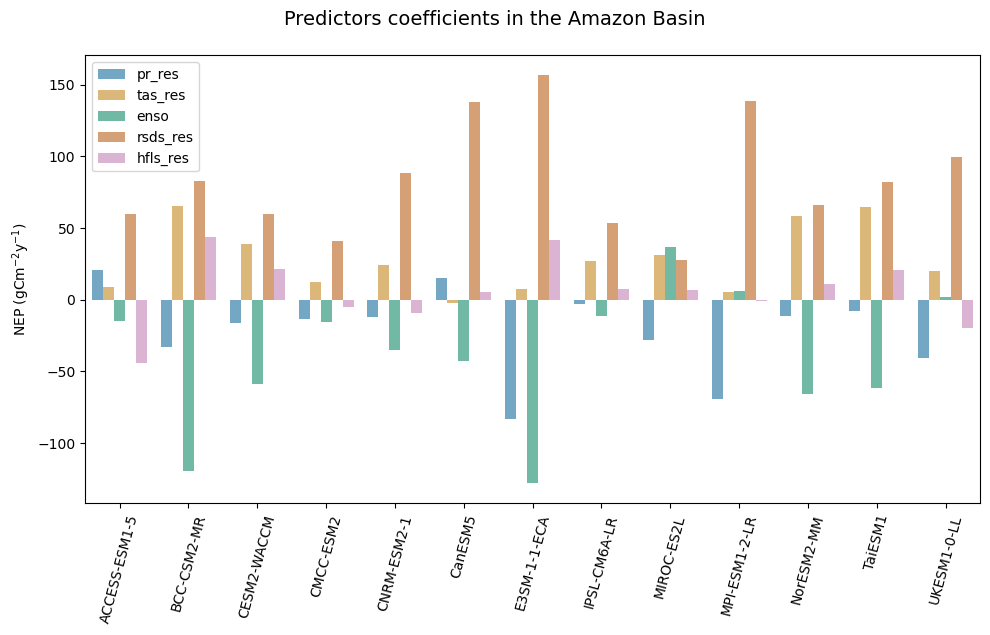

In [35]:
import seaborn as sns

df_amz = df_amz.rename(columns = {"nep":"nep_pred", "pr":"pr_res", "tas":"tas_res", "rsds":"rsds_res", "hfls":"hfls_res" })
df_amz["esm"] = df_amz.index
df_amz_long = pd.melt(df_amz,id_vars="esm", var_name="effect")
data = df_amz_long[(df_amz_long['effect'] != 'nep_pred')].copy()

fig = plt.figure(figsize=(10, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(111)
ax0 = sns.barplot(
    data=data.rename(columns={'effect': 'variable'}), hue="variable",# errorbar=("pi", 60),
    x="esm", y="value",
    palette='colorblind', alpha=.6, 
)
# ax0.set_ylim(-150, 200)
ax0.set_xticklabels(sorted(list(set(esm))) , rotation = 75)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("NEP (gCm$^{-2}$y$^{-1}$)")
# ax0.set_title("a) historical")

fig.tight_layout()
title = 'Predictors coefficients in the Amazon Basin'
fig.suptitle(title, y = 1.05, fontsize = 14)
output_file = os.path.join(out_path, title) + "_c_trend_deseason.png"


Compare MLR_trend vs MLR_notrend

In [3]:
df_mlr = pd.read_csv(os.path.join(out_path,"df_coeff_mlr.csv")).drop(columns = "Unnamed: 0")
mlr_diff = data.copy()
mlr_diff["value"] = (data["value"].values - df_mlr[(df_mlr['effect'] != 'nep_pred') & (df_mlr['effect'] != 'nep')]["value"].values)
mlr_diff

NameError: name 'out_path' is not defined

Scatterplot of NEP vs predictors

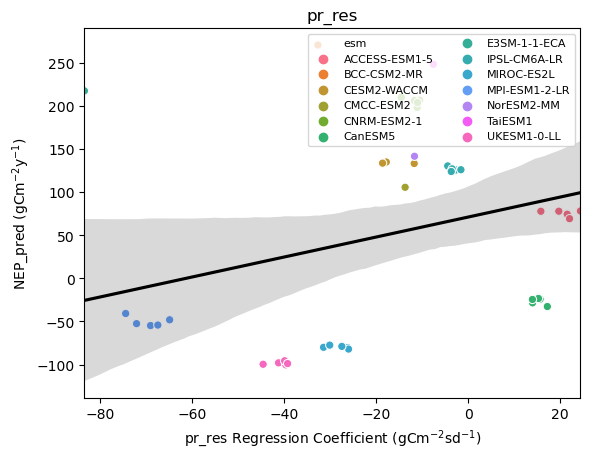

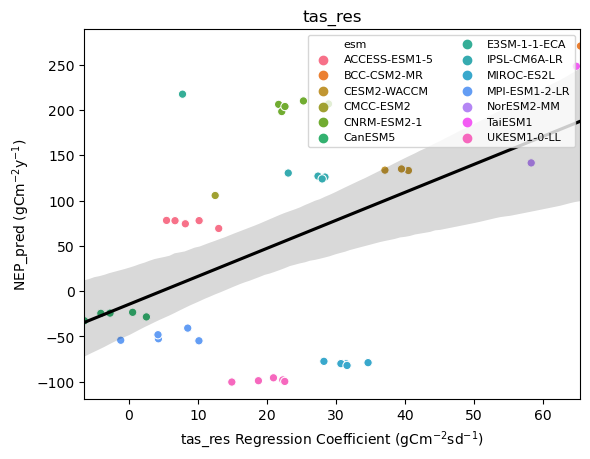

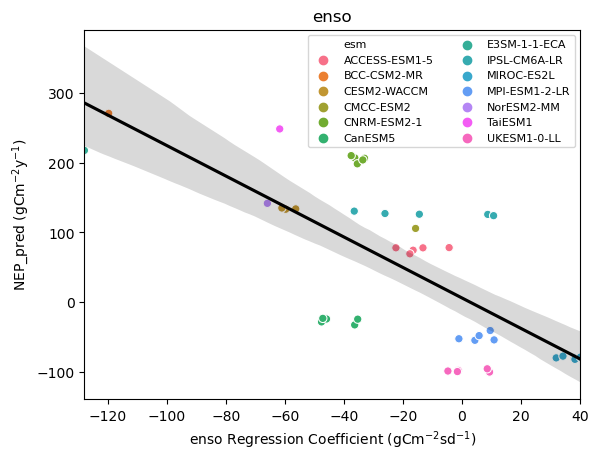

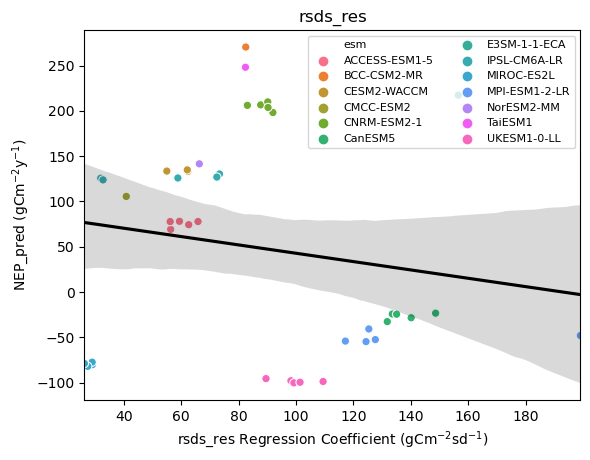

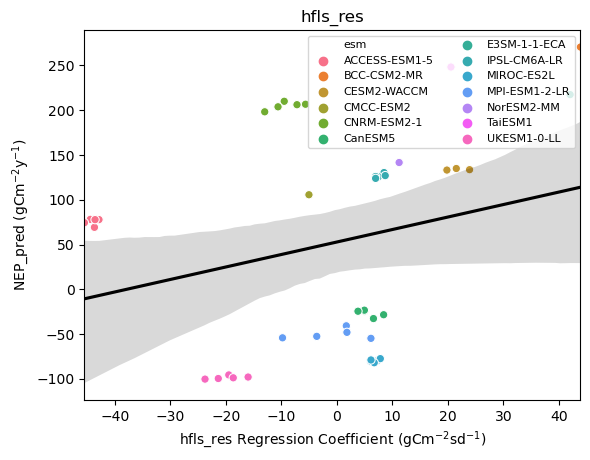

In [55]:
import seaborn as sns

for predictor in ["pr_res", "tas_res", "enso", "rsds_res", "hfls_res"]:
    
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax = sns.scatterplot(predictor, 'nep_pred', data=df_amz, hue=df_amz.index)
    ax = sns.regplot(x=predictor, y='nep_pred', data=df_amz, scatter=False, line_kws={"color": "black"})
    ax.set(xlabel=predictor + ' Regression Coefficient (gCm$^{-2}$sd$^{-1}$)', ylabel='NEP_pred (gCm$^{-2}$y$^{-1}$)')
    title= "model diversity - ssp585 " + predictor
    ax.set_title(predictor)
    ax.legend(loc='upper right', ncol=2, fontsize = 8)
    output_file = os.path.join(out_path, title) + "_c.png"
    # plt.savefig(output_file, bbox_inches='tight')